### Goals:



#### G1: Given probability distributions $p$ and $q$, find the divergence (measure of similarity) between them

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? 

![](dkl.png)

To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a || b)$ where $a$ and $b$ are the two distributions. 

For G1, we can say $q_2$ is closer to $p$ compared to $q_1$ as:

$D_{KL}(q_2 || p) \lt D_{KL}(q_1 || p)$

For the above example, we have the values as $D_{KL}(q_2|| p) = 0.07$ and $D_{KL}(q_1|| p)= 0.35$

#### G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

The following GIF shows the process of finding the optimum set of parameters for a normal distribution $q$ so that it becomes as close as possible to $p$. This is equivalent of minimizing $D_{KL}(q || p)$


![](kl_qp.gif)

The following GIF shows the above but for a two-dimensional distribution.


![](kl_qp_2.gif)

#### G3: finding the "distance" between two distributions of different families


The below image shows the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](dkl-different.png)


#### G4: optimizing the "distance" between two distributions of different families

The below GIF shows the optimization of the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](kl_qp_mg.gif)


#### G5: Approximating the KL-divergence

#### G6: Implementing variational inference for linear regression




### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating distributions

#### Creating $p\sim\mathcal{N}(1.00, 4.00)$

In [2]:
p = dist.Normal(1, 4)

Text(0, 0.5, 'PDF')

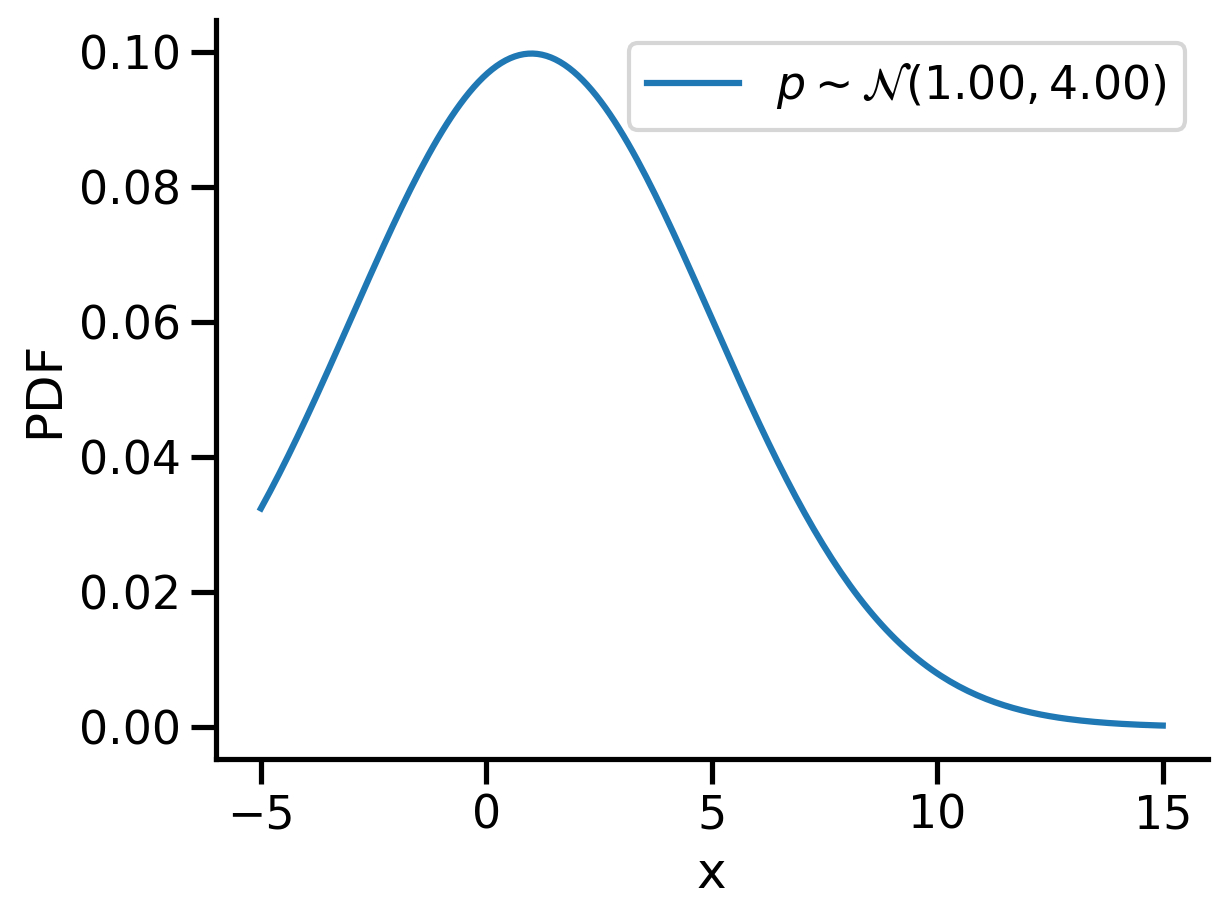

In [4]:
z_values = torch.linspace(-5, 15, 200)
prob_values_p = torch.exp(p.log_prob(z_values))
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$")
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

#### Creating $q\sim\mathcal{N}(loc, scale)$

In [5]:
def create_q(loc, scale):
    return dist.Normal(loc, scale)

#### Generating a few qs for different location and scale value

In [6]:
q = {}
q[(0, 1)] = create_q(0.0, 1.0)

for loc in [0, 1]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_q(float(loc), float(scale))

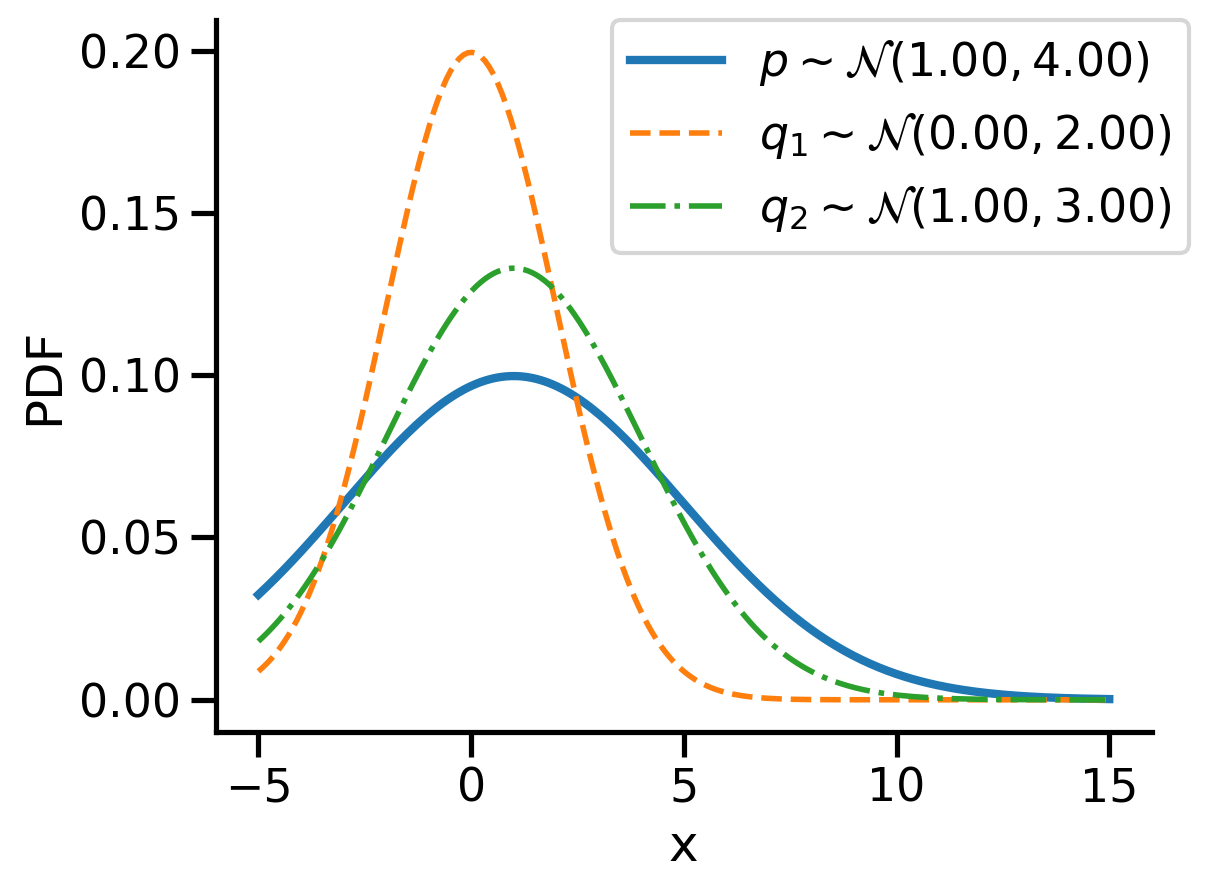

In [7]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=3)
plt.plot(
    z_values,
    torch.exp(create_q(0.0, 2.0).log_prob(z_values)),
    label=r"$q_1\sim\mathcal{N}(0.00, 2.00)$",
    lw=2,
    linestyle="--",
)
plt.plot(
    z_values,
    torch.exp(create_q(1.0, 3.0).log_prob(z_values)),
    label=r"$q_2\sim\mathcal{N}(1.00, 3.00)$",
    lw=2,
    linestyle="-.",
)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig(
    "dkl.png",
    dpi=150,
)

In [8]:
#### Computing KL-divergence

q_0_2_dkl = dist.kl_divergence(create_q(0.0, 2.0), p)
q_1_3_dkl = dist.kl_divergence(create_q(1.0, 3.0), p)

print(f"D_KL (q(0, 2)||p) = {q_0_2_dkl:0.2f}")
print(f"D_KL (q(1, 3)||p) = {q_1_3_dkl:0.2f}")

D_KL (q(0, 2)||p) = 0.35
D_KL (q(1, 3)||p) = 0.07


As mentioned earlier, clearly, $q_2\sim\mathcal{N}(1.00, 3.00)$ seems closer to $p$

### Optimizing the KL-divergence between q and p

We could create a grid of (loc, scale) pairs and find the best, as shown below.

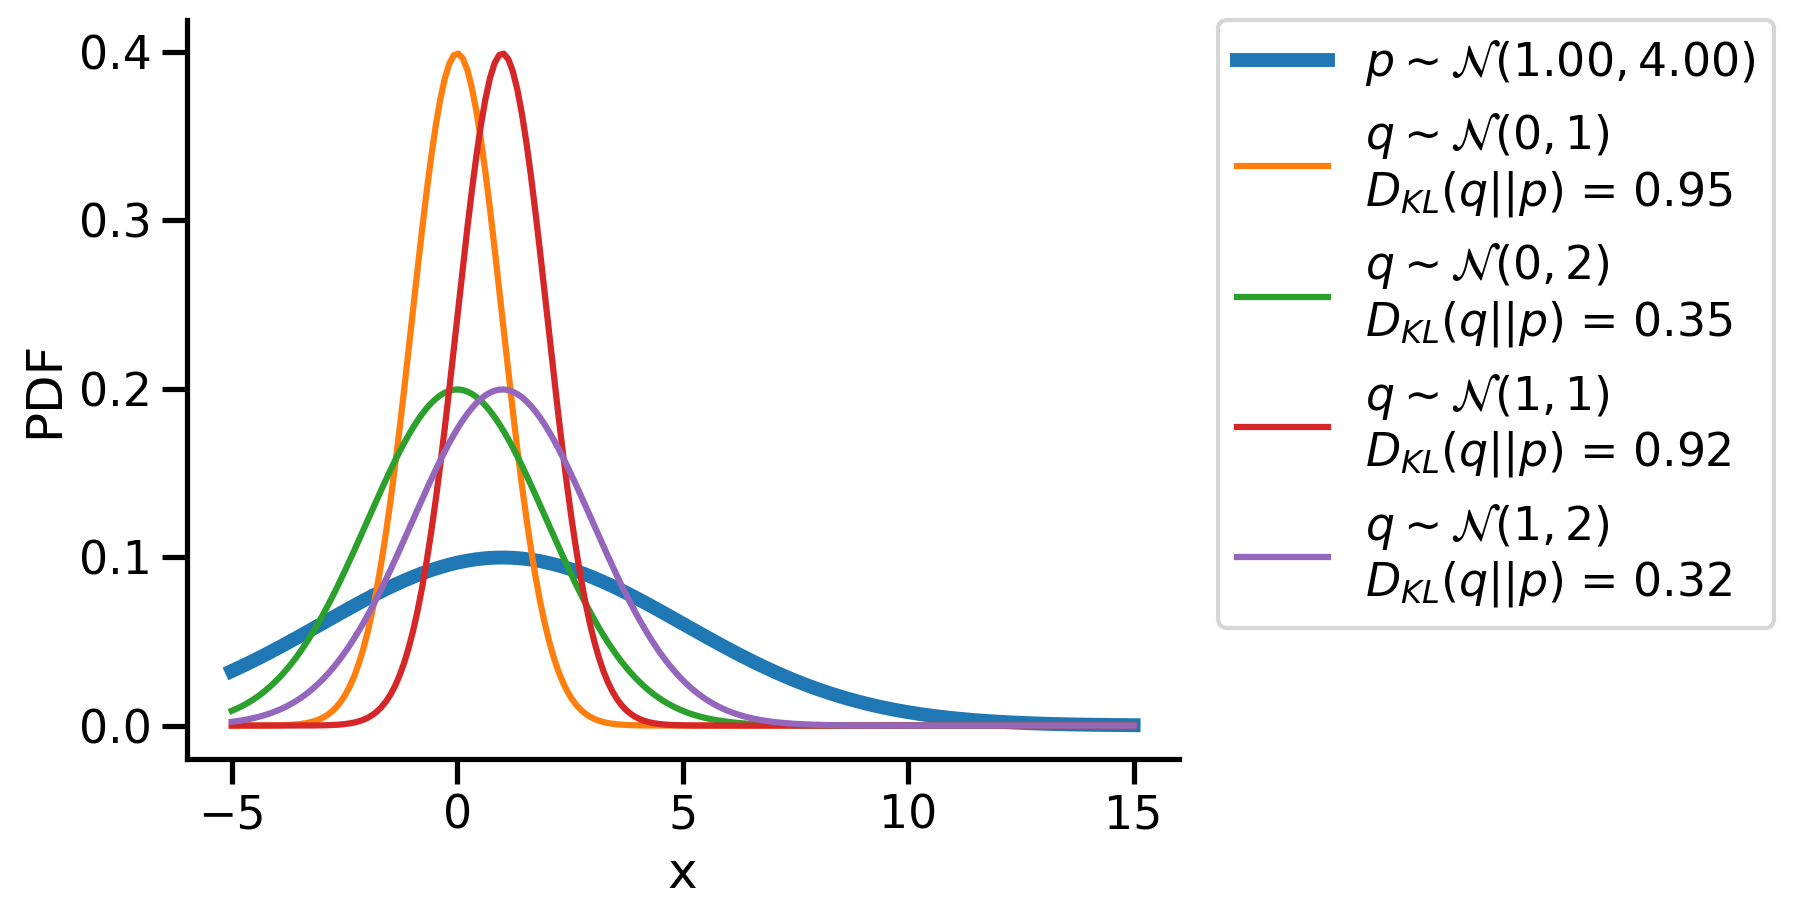

In [9]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)


for loc in [0, 1]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = dist.kl_divergence(q[(loc, scale)], p)
        plt.plot(
            z_values,
            torch.exp(q_d.log_prob(z_values)),
            label=rf"$q\sim\mathcal{{N}}({loc}, {scale})$"
            + "\n"
            + rf"$D_{{KL}}(q||p)$ = {kl_d:0.2f}",
        )
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

Or, we could use continuous optimization to find the best loc and scale parameters for q.

In [10]:
loc = torch.tensor(8.0, requires_grad=True)
scale = torch.tensor(0.1, requires_grad=True)


loc_array = []
scale_array = []
loss_array = []
opt = torch.optim.Adam([loc, scale], lr=0.05)
for i in range(401):
    scale_softplus = torch.functional.F.softplus(scale)

    to_learn = dist.Normal(loc=loc, scale=scale_softplus)
    loss = dist.kl_divergence(to_learn, p)
    loss_array.append(loss.item())
    loc_array.append(to_learn.loc.item())
    scale_array.append(to_learn.scale.item())

    loss.backward()
    if i % 100 == 0:
        print(
            f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc.item():0.2f}, Scale: {scale_softplus.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 2.73, Loc: 8.00, Scale: 0.74
Iteration: 100, Loss: 0.26, Loc: 3.75, Scale: 3.46
Iteration: 200, Loss: 0.01, Loc: 1.68, Scale: 3.98
Iteration: 300, Loss: 0.00, Loc: 1.10, Scale: 4.00
Iteration: 400, Loss: 0.00, Loc: 1.01, Scale: 4.00


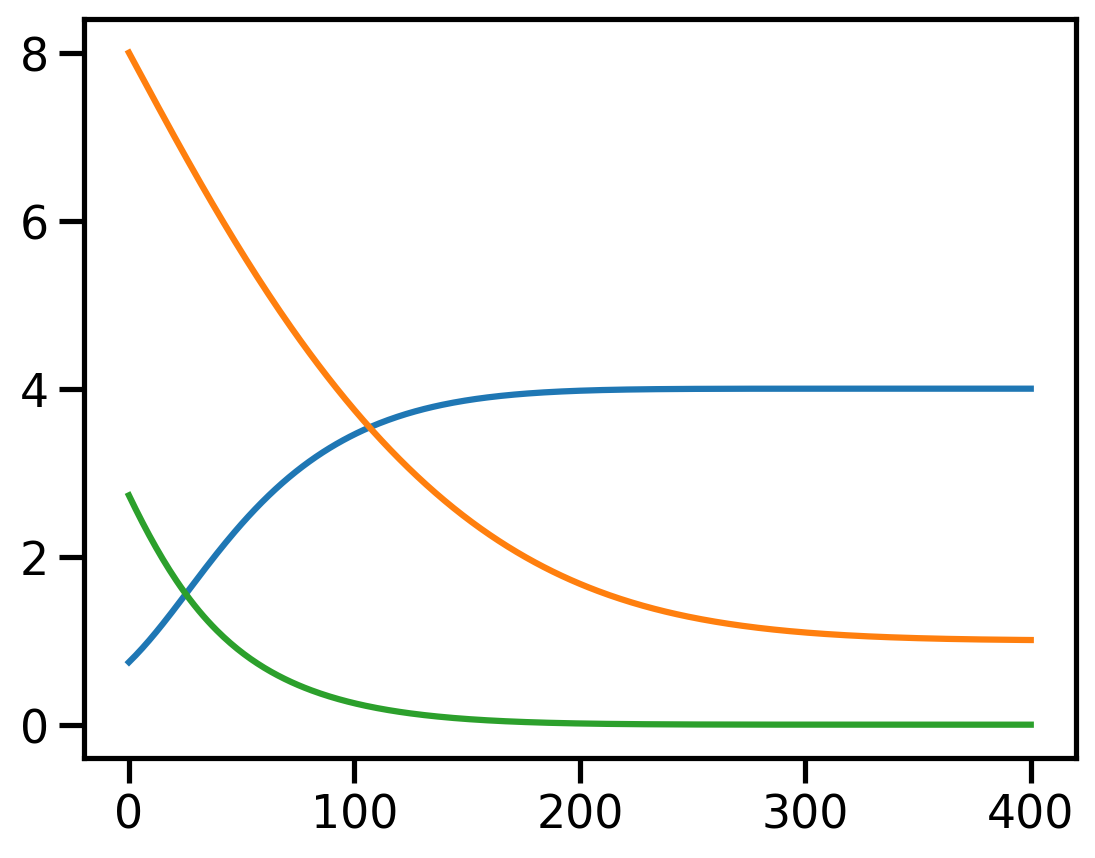

In [11]:
plt.plot(torch.tensor(scale_array))
plt.plot(torch.tensor(loc_array))
plt.plot(torch.tensor(loss_array))

After training, we are able to recover the scale and loc very close to that of $p$

### Animation!

In [12]:
from matplotlib import animation

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()    


def animate(i):
    ax.clear()
    ax.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)
    to_learn_q = dist.Normal(loc = loc_array[i], scale=scale_array[i])
    loss = loss_array[i]
    ax.plot(
        z_values,
        torch.exp(to_learn_q.log_prob(z_values)),
        label=rf"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$",
    )

    ax.set_title(rf"Iteration: {i}, $D_{{KL}}(q||p)$: {loss:0.2f}")
    ax.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))

    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()


ani = animation.FuncAnimation(fig, animate, frames=350)
plt.close()

In [13]:
ani.save("kl_qp.gif", writer="imagemagick", fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

![](kl_qp.gif)

![](kl_qp.gif)

### Finding the KL divergence for two distributions from different families

Let us rework our example with `p` coming from  a mixture of Gaussian distribution and `q` being Normal.

In [14]:
p_s = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=torch.tensor([0.5, 0.5])),
    component_distribution=dist.Normal(
        loc=torch.tensor([-0.2, 1]), scale=torch.tensor([0.4, 0.5])  # One for each component.
    ),
)  

p_s

MixtureSameFamily(
  Categorical(probs: torch.Size([2]), logits: torch.Size([2])),
  Normal(loc: torch.Size([2]), scale: torch.Size([2])))

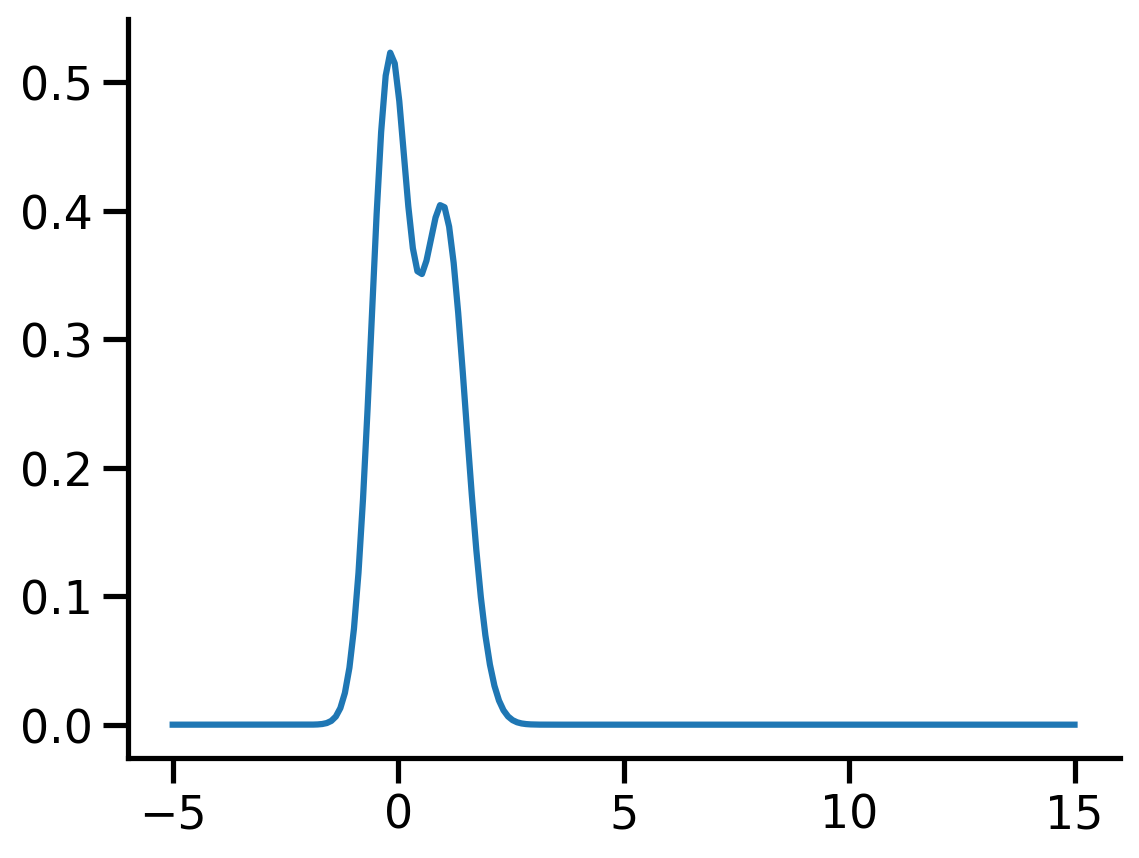

In [15]:
plt.plot(z_values, torch.exp(p_s.log_prob(z_values)))
sns.despine()

Let us create two Normal distributions q_1 and q_2 and plot them to see which looks closer to p_s.

In [16]:
q_1 = create_q(3, 1)
q_2 = create_q(3, 4.5)

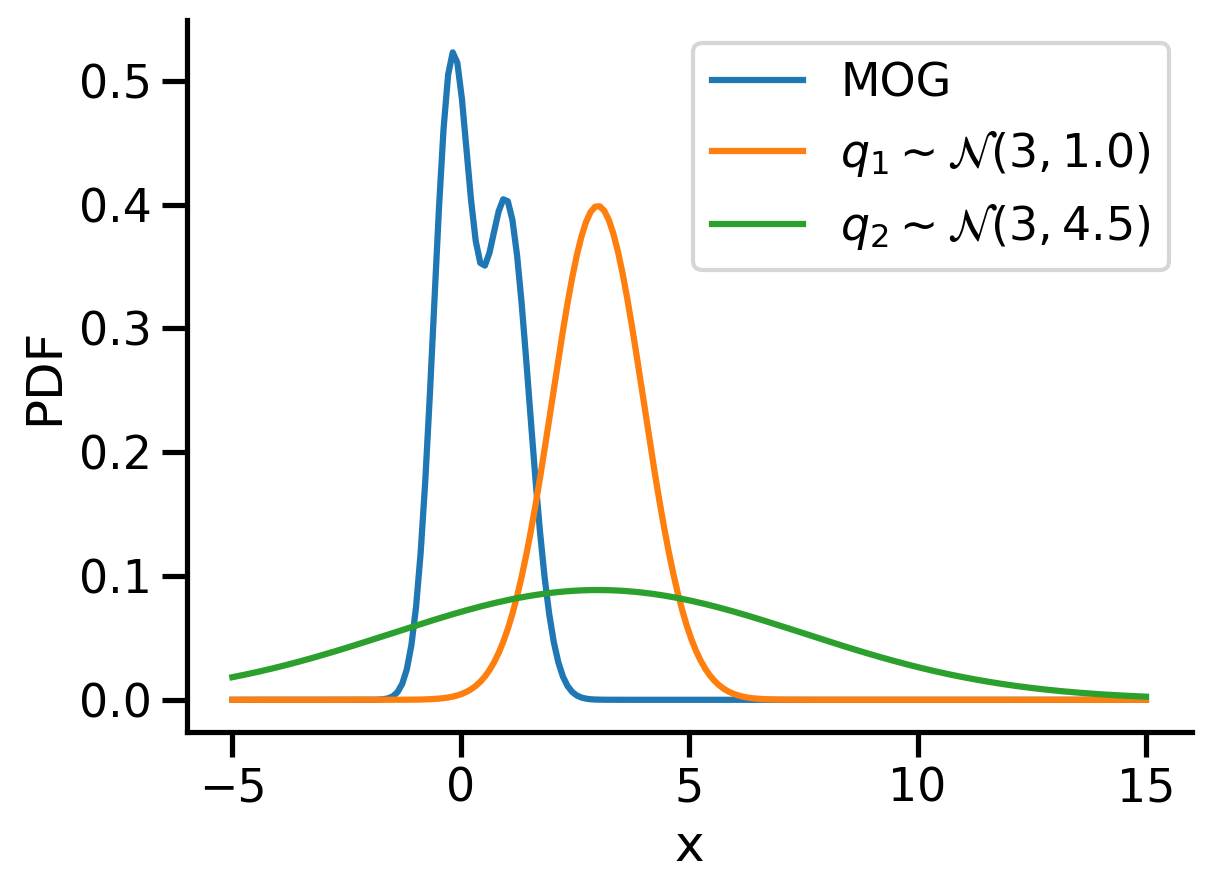

In [17]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))
prob_values_q_1 = torch.exp(q_1.log_prob(z_values))
prob_values_q_2 = torch.exp(q_2.log_prob(z_values))

plt.plot(z_values, prob_values_p_s, label=r"MOG")
plt.plot(z_values, prob_values_q_1, label=r"$q_1\sim\mathcal{N} (3, 1.0)$")
plt.plot(z_values, prob_values_q_2, label=r"$q_2\sim\mathcal{N} (3, 4.5)$")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig(
    "dkl-different.png",
    dpi=150,
)

In [18]:
try:
    dist.kl_divergence(q_1, p_s)
except NotImplementedError:
    print(f"KL divergence not implemented between {q_1.__class__} and {p_s.__class__}")

KL divergence not implemented between <class 'torch.distributions.normal.Normal'> and <class 'torch.distributions.mixture_same_family.MixtureSameFamily'>


As we see above, we can not compute the KL divergence directly. The core idea would now be to leverage the Monte Carlo sampling and generating the expectation. The following function does that.

In [19]:
def kl_via_sampling(q, p, n_samples=100000):
    # Get samples from q
    sample_set = q.sample([n_samples])
    # Use the definition of KL-divergence
    return torch.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [20]:
dist.kl_divergence(q_1, q_2)

tensor(1.0288)

In [21]:
kl_via_sampling(q_1, q_2)

tensor(1.0285)

In [22]:
kl_via_sampling(q_1, p_s), kl_via_sampling(q_2, p_s)

(tensor(9.4883), tensor(44.9640))

As we can see from KL divergence calculations, `q_1` is closer to our Gaussian mixture distribution.

### Optimizing the KL divergence for two distributions from different families

We saw that we can calculate the KL divergence between two different distribution families via sampling. But, as we did earlier, will we be able to optimize the parameters of our target surrogate distribution? The answer is No! As we have introduced sampling. However, there is still a way -- by reparameterization! 

Our surrogate q in this case is parameterized by `loc` and `scale`. The key idea here is to generate samples from a standard normal distribution (loc=0, scale=1) and then apply an affine transformation on the generated samples to get the samples generated from q. See my other post on sampling from normal distribution to understand this better.

The loss can now be thought of as a function of `loc` and `scale`.

In [19]:
n_samples = 1000


def loss(loc, scale):
    q = dist.Normal(loc=loc, scale=scale)
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample([n_samples])
    sample_set = loc + scale * sample_set
    return torch.mean(q.log_prob(sample_set) - p_s.log_prob(sample_set))

Having defined the loss above, we can now optimize `loc` and `scale` to minimize the KL-divergence.

In [21]:
loc = torch.tensor(8.0, requires_grad=True)
scale = torch.tensor(0.1, requires_grad=True)


loc_array = []
scale_array = []
loss_array = []
opt = torch.optim.Adam([loc, scale], lr=0.05)
for i in range(401):
    scale_softplus = torch.functional.F.softplus(scale)

    to_learn = dist.Normal(loc=loc, scale=scale_softplus)
    loss_value = loss(loc, scale_softplus)
    loss_array.append(loss_value.item())
    loc_array.append(to_learn.loc.item())
    scale_array.append(to_learn.scale.item())

    loss_value.backward()
    if i % 100 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_value.item():0.2f}, Loc: {loc.item():0.2f}, Scale: {scale_softplus.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 97.83, Loc: 8.00, Scale: 0.74
Iteration: 100, Loss: 15.45, Loc: 3.75, Scale: 0.48
Iteration: 200, Loss: 1.60, Loc: 1.67, Scale: 0.52
Iteration: 300, Loss: 0.33, Loc: 0.96, Scale: 0.69
Iteration: 400, Loss: 0.10, Loc: 0.62, Scale: 0.75


In [22]:
q_s = dist.Normal(loc=loc, scale=scale_softplus)
q_s

Normal(loc: 0.6200916767120361, scale: 0.7453544735908508)

Text(0, 0.5, 'PDF')

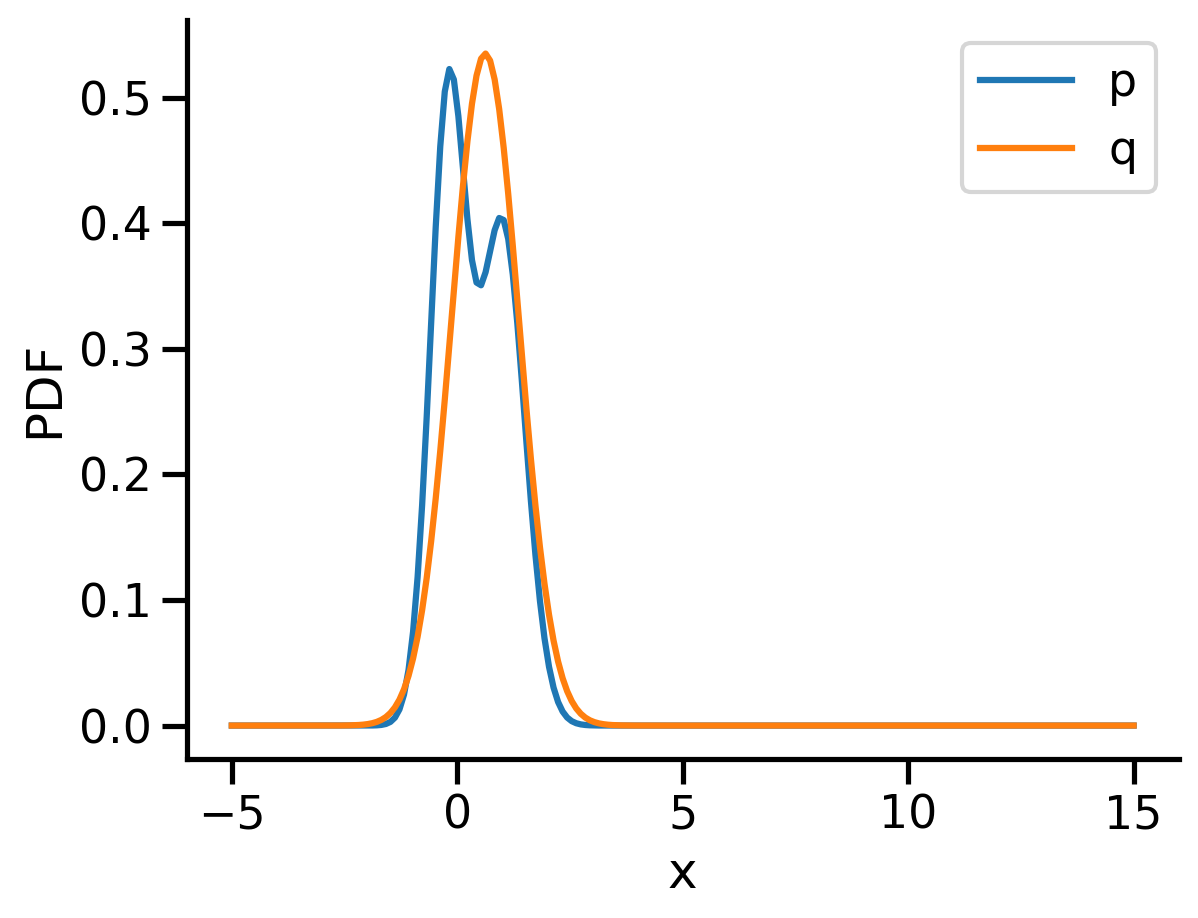

In [23]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))
prob_values_q_s = torch.exp(q_s.log_prob(z_values))

plt.plot(z_values, prob_values_p_s.detach(), label=r"p")
plt.plot(z_values, prob_values_q_s.detach(), label=r"q")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [123]:
prob_values_p_s = torch.exp(p_s.log_prob(z_values))

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()
n_iter = 300

def a(iteration):

    ax.clear()
    loc = loc_array[iteration]
    scale = scale_array[iteration]
    q_s = dist.Normal(loc=loc, scale=scale)

    prob_values_q_s = torch.exp(q_s.log_prob(z_values))

    ax.plot(z_values, prob_values_p_s, label=r"p")
    ax.plot(z_values, prob_values_q_s, label=r"q")
    ax.set_title(f"Iteration {iteration}, Loss: {loss_array[iteration]:0.2f}")
    ax.set_ylim((-0.05, 1.05))
    ax.legend()

ani_mg = animation.FuncAnimation(fig, a, frames=n_iter)
plt.close()

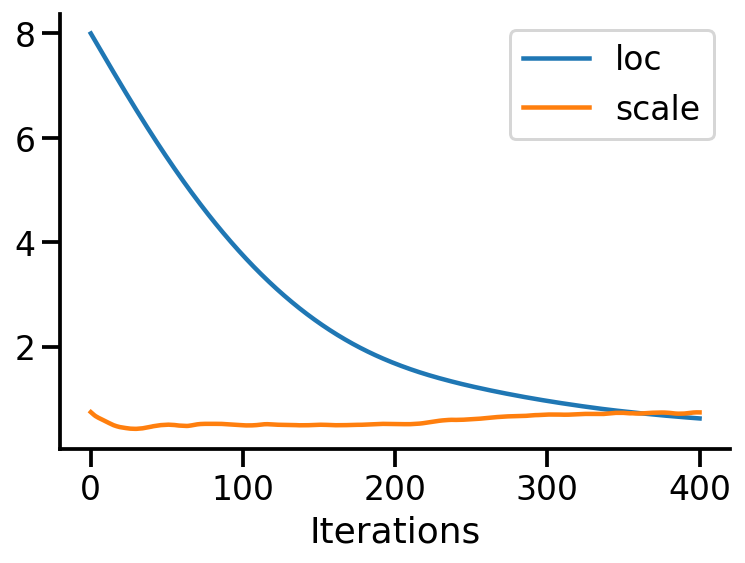

In [124]:
plt.plot(loc_array, label="loc")
plt.plot(scale_array, label="scale")
plt.xlabel("Iterations")
sns.despine()
plt.legend()

In [125]:
ani_mg.save("kl_qp_mg.gif", writer="imagemagick")

![](kl_qp_mg.gif)

#### KL-Divergence and ELBO

Let us consider linear regression. We have parameters $\theta \in R^D$ and we define a prior over them. Let us assume we define prior $p(\theta)\sim \mathcal{N_D} (\mu, \Sigma)$. Now, given our dataset $D = \{X, y\}$ and a parameter vector $\theta$, we can deifine our likelihood as $p(D|\theta)$ or $p(y|X, \theta) = \prod_{i=1}^{n} p(y_i|x_i, \theta) = \prod_{i=1}^{n} \mathcal{N}(y_i|x_i^T\theta, \sigma^2) $

As per Bayes rule, we can obtain the posterior over $\theta$ as:

$p(\theta|D) = \dfrac{p(D|\theta)p(\theta)}{p(D)}$

Now, in general $p(D)$ is hard to compute. 

So, in variational inference, our aim is to use a surrogate distribution $q(\theta)$ such that it is very close to $p(\theta|D)$. We do so by minimizing the KL divergence between $q(\theta)$ and $p(\theta|D)$.

Aim: $$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

Now,  $$D_{KL}[q(\theta)||p(\theta|D)] = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)}{p(\theta|D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)p(D)}{p(\theta, D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \mathbb{E}_{q(\theta)}[\log p(D)] $$
$$= \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \log p(D) $$

Now, $p(D) \in \{0, 1\}$. Thus, $\log p(D) \in \{-\infty, 0 \}$

Now, let us look at the quantities:

$$\underbrace{D_{KL}[q(\theta)||p(\theta|D)]}_{\geq 0} = \underbrace{\mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)]}_{-\text{ELBO(q)}} +  \underbrace{\log p(D)}_{\leq 0}$$

Thus, we know that $\log p(D) \geq \text{ELBO(q)}$

Thus, finally we can rewrite the optimisation from

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

to

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmax~}} \text{ELBO(q)}$$


Now, given our linear regression problem setup, we want to maximize the ELBO.

We can do so by the following. As a simple example, let us assume $\theta \in R^2$

- Assume some q. Say, a Normal distribution. So, $q\sim \mathcal{N}_2$
- Draw samples from q. Say N samples. 
- Initilize ELBO = 0.0
- For each sample:
    - Let us assume drawn sample is $[\theta_1, \theta_2]^T$
    - Compute log_prob of prior on $[\theta_1, \theta_2]^T$ or `lp = p.log_prob(θ1, θ2)`
    - Compute log_prob of likelihood on $[\theta_1, \theta_2]^T$ or `ll = l.log_prob(θ1, θ2)`
    - Compute log_prob of q on $[\theta_1, \theta_2]^T$ or `lq = q.log_prob(θ1, θ2)`
    - ELBO = ELBO + (ll+lp-q)
- Return ELBO/N

In [142]:
prior = dist.Normal(loc = 0., scale = 1.)
p = dist.Normal(loc = 5., scale = 1.)

In [143]:
samples = p.sample([1000])

In [177]:
mu = torch.tensor(1.0, requires_grad=True)

def surrogate_sample(mu):
    std_normal = dist.Normal(loc = 0., scale=1.)
    sample_std_normal  = std_normal.sample()
    return mu + sample_std_normal


In [178]:
samples_from_surrogate = surrogate_sample(mu)

In [179]:
samples_from_surrogate

tensor(2.7988, grad_fn=<AddBackward0>)

In [180]:
def logprob_prior(mu):
    return prior.log_prob(mu)

lp = logprob_prior(samples_from_surrogate)

def log_likelihood(mu, samples):
    di = dist.Normal(loc=mu, scale=1)
    return torch.sum(di.log_prob(samples))

ll = log_likelihood(samples_from_surrogate, samples)

ls = surrogate.log_prob(samples_from_surrogate)



In [181]:
def elbo_loss(mu, data_samples):
    samples_from_surrogate = surrogate_sample(mu)
    lp = logprob_prior(samples_from_surrogate)
    ll = log_likelihood(samples_from_surrogate, data_samples)
    ls = surrogate.log_prob(samples_from_surrogate)

    return -lp - ll + ls

In [188]:
mu = torch.tensor(1.0, requires_grad=True)

loc_array = []
loss_array = []

opt = torch.optim.Adam([mu], lr=0.02)
for i in range(2000):
    loss_val = elbo_loss(mu, samples)
    loss_val.backward()
    loc_array.append(mu.item())
    loss_array.append(loss_val.item())

    if i % 100 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {mu.item():0.3f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 11693.85, Loc: 1.000
Iteration: 100, Loss: 2550.90, Loc: 2.744
Iteration: 200, Loss: 2124.30, Loc: 3.871
Iteration: 300, Loss: 2272.48, Loc: 4.582
Iteration: 400, Loss: 2025.17, Loc: 4.829
Iteration: 500, Loss: 1434.45, Loc: 5.079
Iteration: 600, Loss: 1693.33, Loc: 5.007
Iteration: 700, Loss: 1495.89, Loc: 4.957
Iteration: 800, Loss: 2698.28, Loc: 5.149
Iteration: 900, Loss: 2819.85, Loc: 5.117
Iteration: 1000, Loss: 1491.79, Loc: 5.112
Iteration: 1100, Loss: 1767.87, Loc: 4.958
Iteration: 1200, Loss: 1535.30, Loc: 4.988
Iteration: 1300, Loss: 1458.61, Loc: 4.949
Iteration: 1400, Loss: 1400.21, Loc: 4.917
Iteration: 1500, Loss: 2613.42, Loc: 5.073
Iteration: 1600, Loss: 1411.46, Loc: 4.901
Iteration: 1700, Loss: 1587.94, Loc: 5.203
Iteration: 1800, Loss: 1461.40, Loc: 5.011
Iteration: 1900, Loss: 1504.93, Loc: 5.076


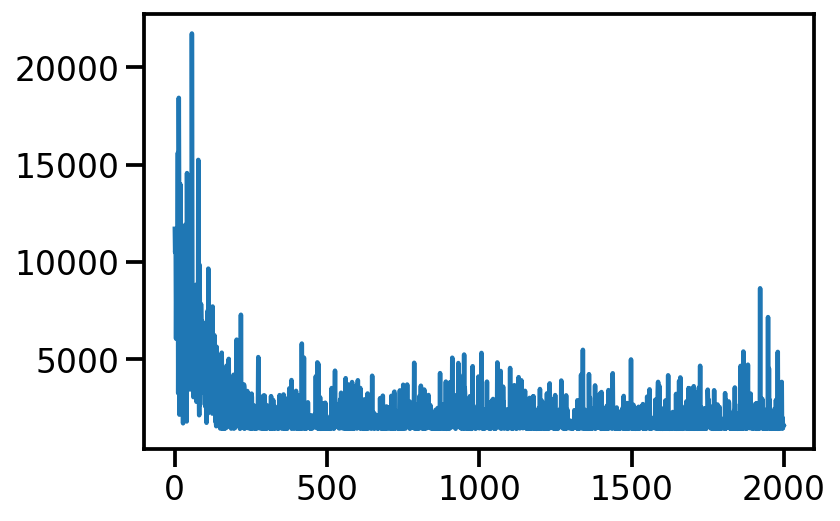

In [189]:
plt.plot(loss_array)

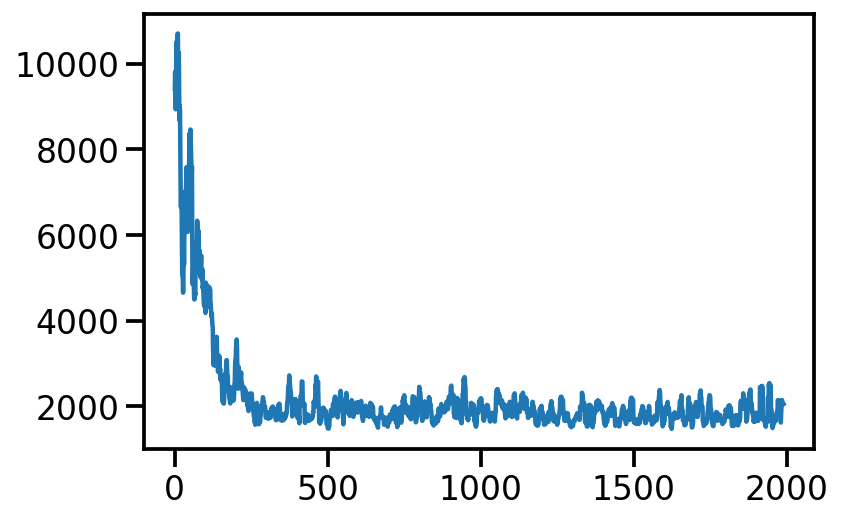

In [192]:
from numpy.lib.stride_tricks import sliding_window_view
plt.plot(np.average(sliding_window_view(loss_array, window_shape = 10), axis=1))

#### Linear Regression



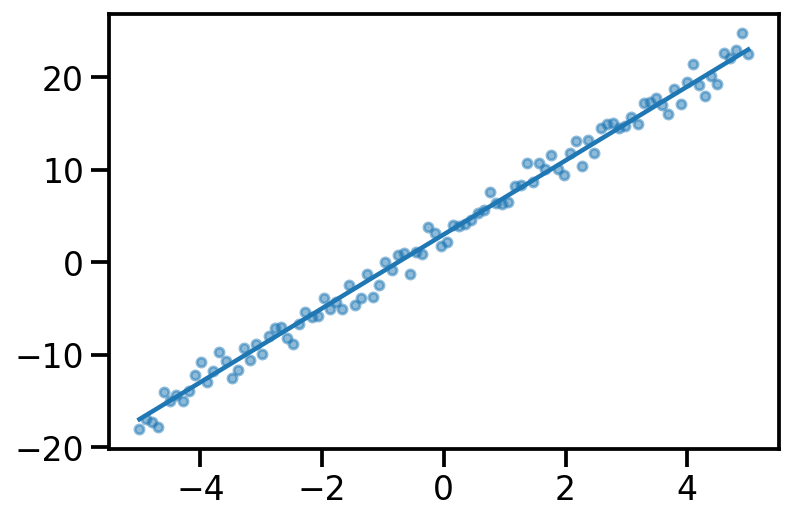

In [201]:
true_theta_0 = 3.
true_theta_1 = 4.

x = torch.linspace(-5, 5, 100)
y_true = true_theta_0 + true_theta_1*x
y_noisy = y_true + torch.normal(mean = torch.zeros_like(x), std = torch.ones_like(x))

plt.plot(x, y_true)
plt.scatter(x, y_noisy, s=20, alpha=0.5)

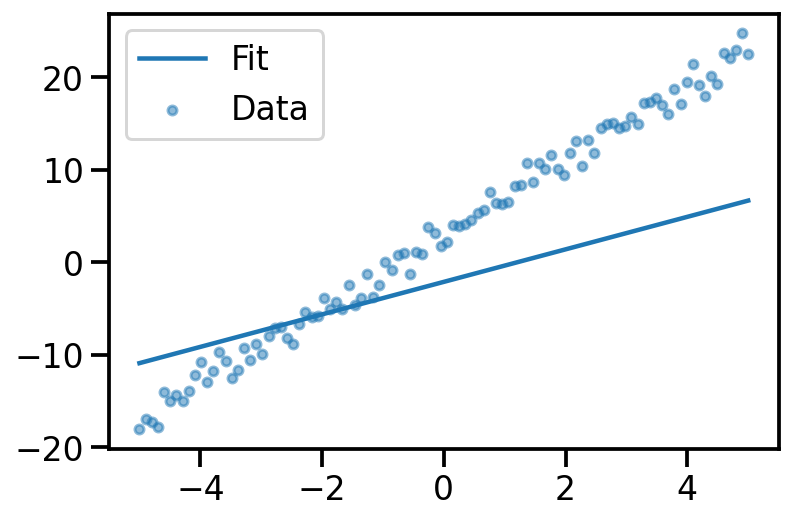

In [227]:
y_pred = x_dash@theta_prior.sample()
plt.plot(x, y_pred, label="Fit")
plt.scatter(x, y_noisy, s=20, alpha=0.5, label='Data')
plt.legend()

In [257]:
theta_prior = dist.MultivariateNormal(loc = torch.tensor([0., 0.]), covariance_matrix=torch.eye(2))


def likelihood(theta, x, y):
    x_dash = torch.vstack((torch.ones_like(x), x)).t()
    d = dist.Normal(loc=x_dash@theta, scale=torch.ones_like(x))
    return torch.sum(d.log_prob(y))

In [258]:
likelihood(theta_prior.sample(), x, y_noisy)

tensor(-3558.0769)

In [259]:
loc = torch.tensor([-1., 1.], requires_grad=True)
surrogate_mvn = dist.MultivariateNormal(loc = loc, covariance_matrix=torch.eye(2))
surrogate_mvn

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [260]:
surrogate_mvn.sample()

tensor([-1.1585,  2.6212])

In [261]:
def surrogate_sample_mvn(loc):
    std_normal_mvn = dist.MultivariateNormal(loc = torch.zeros_like(loc), covariance_matrix=torch.eye(loc.shape[0]))
    sample_std_normal  = std_normal_mvn.sample()
    return loc + sample_std_normal


In [265]:
def elbo_loss(loc, x, y):
    samples_from_surrogate_mvn = surrogate_sample_mvn(loc)
    lp = theta_prior.log_prob(samples_from_surrogate_mvn)
    ll = likelihood(samples_from_surrogate_mvn, x, y_noisy)
    ls = surrogate_mvn.log_prob(samples_from_surrogate_mvn)

    return -lp - ll + ls

In [266]:
loc.shape, x.shape, y_noisy.shape

(torch.Size([2]), torch.Size([100]), torch.Size([100]))

In [267]:
elbo_loss(loc, x, y_noisy)

tensor(2850.3154, grad_fn=<AddBackward0>)

In [272]:
loc = torch.tensor([-1., 1.], requires_grad=True)


loc_array = []
loss_array = []

opt = torch.optim.Adam([loc], lr=0.02)
for i in range(10000):
    loss_val = elbo_loss(loc, x, y_noisy)
    loss_val.backward()
    loc_array.append(mu.item())
    loss_array.append(loss_val.item())

    if i % 1000 == 0:
        print(
            f"Iteration: {i}, Loss: {loss_val.item():0.2f}, Loc: {loc}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 5479.97, Loc: tensor([-1.,  1.], requires_grad=True)
Iteration: 1000, Loss: 566.63, Loc: tensor([2.9970, 4.0573], requires_grad=True)
Iteration: 2000, Loss: 362.19, Loc: tensor([2.9283, 3.9778], requires_grad=True)
Iteration: 3000, Loss: 231.23, Loc: tensor([2.8845, 4.1480], requires_grad=True)
Iteration: 4000, Loss: 277.94, Loc: tensor([2.9284, 3.9904], requires_grad=True)
Iteration: 5000, Loss: 1151.51, Loc: tensor([2.9620, 4.0523], requires_grad=True)
Iteration: 6000, Loss: 582.19, Loc: tensor([2.8003, 4.0540], requires_grad=True)
Iteration: 7000, Loss: 178.48, Loc: tensor([2.8916, 3.9968], requires_grad=True)
Iteration: 8000, Loss: 274.76, Loc: tensor([3.0807, 4.1957], requires_grad=True)
Iteration: 9000, Loss: 578.37, Loc: tensor([2.9830, 4.0174], requires_grad=True)


In [275]:
learnt_surrogate = dist.MultivariateNormal(loc = loc, covariance_matrix=torch.eye(2))

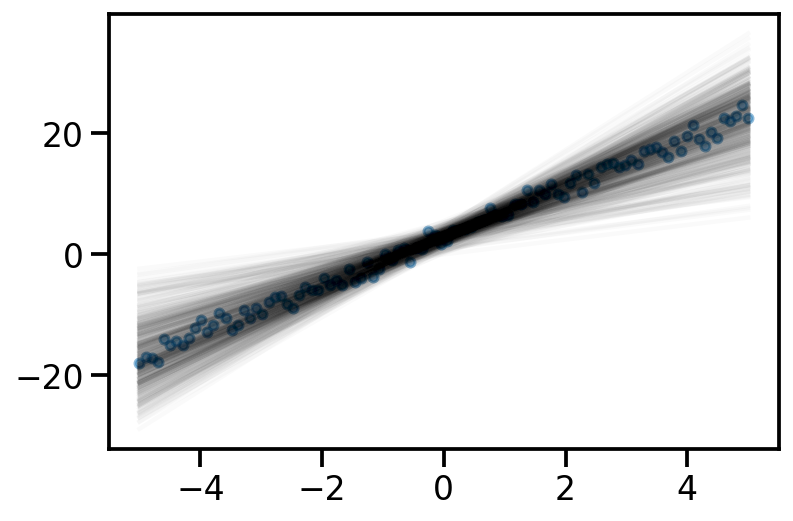

In [296]:
y_samples_surrogate = x_dash@learnt_surrogate.sample([500]).t()
plt.plot(x, y_samples_surrogate, alpha = 0.02, color='k');
plt.scatter(x, y_noisy, s=20, alpha=0.5)

In [299]:
x_dash@learnt_surrogate.loc.detach().t()
theta_sd = torch.linalg.cholesky(learnt_surrogate.covariance_matrix)


#y_samples_surrogate = x_dash@learnt_surrogate.loc.t()
#plt.plot(x, y_samples_surrogate, alpha = 0.02, color='k');
#plt.scatter(x, y_noisy, s=20, alpha=0.5)

tensor([-1.6542e+01, -1.6148e+01, -1.5754e+01, -1.5360e+01, -1.4966e+01,
        -1.4572e+01, -1.4178e+01, -1.3784e+01, -1.3390e+01, -1.2996e+01,
        -1.2602e+01, -1.2208e+01, -1.1814e+01, -1.1420e+01, -1.1026e+01,
        -1.0632e+01, -1.0238e+01, -9.8441e+00, -9.4501e+00, -9.0561e+00,
        -8.6621e+00, -8.2681e+00, -7.8741e+00, -7.4801e+00, -7.0860e+00,
        -6.6920e+00, -6.2980e+00, -5.9040e+00, -5.5100e+00, -5.1160e+00,
        -4.7220e+00, -4.3280e+00, -3.9340e+00, -3.5400e+00, -3.1460e+00,
        -2.7520e+00, -2.3579e+00, -1.9639e+00, -1.5699e+00, -1.1759e+00,
        -7.8191e-01, -3.8790e-01,  6.1054e-03,  4.0011e-01,  7.9412e-01,
         1.1881e+00,  1.5821e+00,  1.9761e+00,  2.3702e+00,  2.7642e+00,
         3.1582e+00,  3.5522e+00,  3.9462e+00,  4.3402e+00,  4.7342e+00,
         5.1282e+00,  5.5222e+00,  5.9162e+00,  6.3102e+00,  6.7043e+00,
         7.0983e+00,  7.4923e+00,  7.8863e+00,  8.2803e+00,  8.6743e+00,
         9.0683e+00,  9.4623e+00,  9.8563e+00,  1.0

TODO

1. Pyro for linear regression example
2. Handle more samples in ELBO
3. Reuse some methods
4. Add figure on reparameterization
5. Linear regression learn covariance also
6. Linear regression posterior compare with analytical posterior (refer Murphy book)
7. Clean up code and reuse code whwrever possible
8. Improve figures and make them consistent
9. Add background maths wherever needed
10. plot the Directed graphical model (refer Maths ML book and render in Pyro)
11. Look at the TFP post on https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression
12. Show the effect of data size (less data, solution towards prior, else dominated by likelihood)
13. Mean Firld (full covariance v/s diagonal) for surrogate

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9
- https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-09-13-02-Minimizing-KL-Divergence.ipynb#scrollTo=gd_ev8ceII8q
- https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/13/02-Minimizing-KL-Divergence.html
